In [1]:
%%capture
!pip install "cvxpy[OSQP]"

In [2]:
!git clone https://github.com/shaoanlu/pyNMPC.git
%cd pyNMPC

Cloning into 'pyNMPC'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 99 (delta 49), reused 46 (delta 20), pack-reused 0 (from 0)
Receiving objects: 100% (99/99), 445.14 KiB | 6.96 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/pyNMPC


## MHE/EKF For Parameter Estimation

This demo shows examples using nonlinnear moving horizon estimation and extended Kalman filter to estimate the payload of a dradrotor suspension.

In [3]:
from nmpc import NMPC, MPCParams, MPCResult
from nmhe import NMHE, MHEParams, MHEResult

### This cell deine the quadrotor suspension
- `dynamics(...)`: the system dynamics. We augment the state of estimate `m_p`, which is the payload.
- `output_fn(...)`: the measurement function that return all state except the augmented payload state.

In [9]:
import numpy as np
import jax
import jax.numpy as jnp
import time

# Quadrotor parameters
m_q = 1.0 # kg
# m_p = 0.2 # kg
I_xx = 0.1 # kg.m^2
l_q = 0.3 # m, length of the quadrotor
l_p = 1.3 # m, length of the pendulum
g = 9.81

def dynamics(x, u, dt, m_q=m_q, mg=g, I_xx=I_xx, l_p=l_p):
    # model adopted from
    # https://github.com/shaoanlu/mppi_cbf/blob/main/planar_quadrotor_pendulum_mppi_cbf.ipynb
    # augment state for m_p, the payload
    y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot, m_p = x
    u1, u2 = u
    total_mass = (m_q + m_p)

    # Quadrotor dynamics
    y_ddot = (m_q + m_p*jnp.cos(theta)**2) / (m_q*total_mass) * u1 * jnp.sin(phi) + \
     (m_p*jnp.cos(theta)*jnp.sin(theta)) / (m_q*total_mass) * u1 * jnp.cos(phi) + \
      (m_p*l_p*(theta_dot**2)*jnp.sin(theta)) / total_mass
    z_ddot = -g + (m_q + m_p*jnp.sin(theta)**2) / (m_q*total_mass) * u1 * jnp.cos(phi) + \
     (m_p*jnp.cos(theta)*jnp.sin(theta)) / (m_q*total_mass) * u1 * jnp.sin(phi) + \
      (m_p*l_p*(theta_dot**2)*jnp.cos(theta)) / total_mass
    phi_ddot = u2 / I_xx
    theta_ddot = -jnp.cos(theta) / (m_q*l_p) * u1 * jnp.sin(phi) - jnp.sin(theta) / (m_q*l_p) * u1 * jnp.cos(phi)

    next_state = x + jnp.array([y_dot, y_ddot, z_dot, z_ddot, phi_dot, phi_ddot, theta_dot, theta_ddot, 0]) * dt
    return next_state

def output_fn(x):
    return x[:-1]  # y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot

### This cell defined the EKF

In [5]:
class ExtendedKalmanFilter:
    def __init__(self, dynamics_fn, output_fn, dt, process_noise_cov, measurement_noise_cov, initial_state, initial_cov):
        """
        Initialize EKF for estimating m_p in the quadrotor-pendulum system.

        Args:
            dynamics_fn: System dynamics function
            output_fn: Measurement function
            dt: Time step
            process_noise_cov: Process noise covariance matrix (Q)
            measurement_noise_cov: Measurement noise covariance matrix (R)
            initial_state: Initial state estimate
            initial_cov: Initial state covariance matrix
        """
        self.dynamics_fn = jax.jit(dynamics_fn)
        self.output_fn = jax.jit(output_fn)
        self.dt = dt
        self.Q = process_noise_cov
        self.R = measurement_noise_cov
        self.x_hat = initial_state
        self.P = initial_cov

        # Calculate Jacobians
        self.F_jacobian = jax.jit(jax.jacfwd(self.dynamics_fn, argnums=0))
        self.H_jacobian = jax.jit(jax.jacfwd(self.output_fn))

    def predict(self, u):
        """
        Prediction step of the EKF.

        Args:
            u: Control input vector [u1, u2]
        """
        # Predict state
        self.x_hat = self.dynamics_fn(self.x_hat, u, self.dt)

        # Calculate state transition matrix (F)
        F = np.array(self.F_jacobian(self.x_hat, u, self.dt))

        # Predict covariance
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        Update step of the EKF.

        Args:
            z: Measurement vector [y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot]
        """
        # Calculate measurement matrix (H)
        H = np.array(self.H_jacobian(self.x_hat))

        # Calculate Kalman gain
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)

        # Update state estimate
        y = z - self.output_fn(self.x_hat)
        self.x_hat = self.x_hat + K @ y

        # Update covariance
        I = np.eye(len(self.x_hat))
        self.P = (I - K @ H) @ self.P

    def get_estimate(self):
        """
        Return the current state estimate.

        Returns:
            Current state estimate vector
        """
        return self.x_hat

# Example usage
def initialize_ekf(m_q, g, I_xx, l_p ,dt):
    # Define dynamics function with fixed parameters
    def dynamics_with_params(x, u, dt):
        return dynamics(x, u, dt, m_q=m_q, mg=g, I_xx=I_xx, l_p=l_p)

    # State dimension (9)
    n_x = 9

    # Measurement dimension (8)
    n_z = 8

    # Define process noise covariance (Q)
    # Tune this based on your expected process noise
    Q = np.eye(n_x) * 0.01
    Q[8, 8] = 0.001  # Lower noise for m_p

    # Define measurement noise covariance (R)
    # Tune this based on your expected measurement noise
    R = np.eye(n_z) * 0.1

    # Initial state estimate
    # [y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot, m_p]
    initial_state = np.zeros(n_x)
    initial_state[8] = 1.0  # Initial guess for m_p

    # Initial state covariance
    initial_cov = np.eye(n_x) * 1.0
    initial_cov[8, 8] = 5.0  # Higher uncertainty for m_p

    # Create EKF instance
    ekf = ExtendedKalmanFilter(
        dynamics_fn=dynamics_with_params,
        output_fn=output_fn,
        dt=dt,
        process_noise_cov=Q,
        measurement_noise_cov=R,
        initial_state=initial_state,
        initial_cov=initial_cov
    )

    return ekf


### Define parameters and precompute simulation

In [6]:
# NMHE parameters
dt = 0.03  # sampling time
N = 10  # horizon length
n_states = 9  # including m_p
n_outputs = 8  # measurements exclude m_p
n_controls = 2
n_est_params = 0  # we include m_p as state, not separate parameter

# Process and measurement noise weightings
Q = jnp.eye(n_states) * 1e-2
Q = Q.at[-1, -1].set(1e-1)  # less penalty on m_p's dynamics (it's constant)
R = jnp.eye(n_outputs) * 1e-2
Px = jnp.eye(n_states) * 1.0  # uncertainty in initial state
Pp = jnp.zeros((1, 1))  # not used since m_p is in state

# Constraints
x_min = jnp.array([-jnp.inf] * (n_states - 1) + [0.05])  # m_p lower bound
x_max = jnp.array([jnp.inf] * (n_states - 1) + [2.0])    # m_p upper bound

# Assemble NMHE parameters
params = MHEParams(
    dt=dt,
    N=N,
    n_states=n_states,
    n_controls=n_controls,
    n_est_params=n_est_params,
    n_outputs=n_outputs,
    Q=Q,
    R=R,
    Px=Px,
    Pp=Pp,
    x_min=x_min,
    x_max=x_max,
    max_sqp_iter=5,
    sqp_tol=1e-4,
    verbose=False
)


# --- Mock simulation data for estimation ---

# Simulate some data (replace with real measurements in practice)
T = 150  # number of time steps
true_m_p = 0.3  # true payload mass for simulation
x_true = jnp.zeros(n_states).at[-1].set(true_m_p)  # true state with payload
control_input = jnp.array([9.81*(m_q+true_m_p), 0.0])
state = dynamics(x_true, control_input, dt)


# Generate synthetic measurements
x_seq = []
y_seq = []
u_seq = []
for t in range(T):
    if t == T//2:
        true_m_p +=1
        state = state.at[-1].set(true_m_p)

    control_input = jnp.array([9.81*(m_q+true_m_p)+0.3*np.sin(2*np.pi*5*t*dt), 0.0])
    u_seq.append(control_input)
    state = dynamics(state, control_input, dt)

    y_meas = output_fn(state)  # + 0.01 * jax.random.normal(jax.random.PRNGKey(t), (n_outputs,))  # add noise
    x_seq.append(state)
    y_seq.append(y_meas)
x_seq = jnp.array(x_seq)


### Run NMHE over the precomputed data

In [10]:
# Initialize NMHE object
nmhe = NMHE(dynamics_fn=dynamics, output_fn=output_fn, params=params)

m_p_estimates = []
computation_times_mhe = []

# Sliding window NMHE estimation
prev_est = None  # previous trajectory guess
for t in range(T - N):
    # Measurement and input sequences over the window
    y_window = y_seq[t:t + N]
    u_window = u_seq[t:t + N]

    # Run NMHE
    meas = x_seq[t].at[-1].set(0.5) if prev_est is None else x_seq[t].at[-1].set(prev_est[-1][-1])
    start_time = time.time()
    res = nmhe.estimate(
        x0=meas,  # assume we know initial state for window (or use previous estimate)
        u_seq=jnp.array(u_window),
        y_seq=jnp.array(y_window),
        prev_est=prev_est
    )
    computation_times_mhe.append(time.time() - start_time)

    # Store estimated m_p (augmented state last element)
    m_p_est = jnp.mean(res.x_est[:, -1])  # average over window
    m_p_estimates.append(m_p_est)

    prev_est = res.x_est  # warm start next iteration
    # print(f"Time {t}, Estimated m_p: {m_p_est:.4f} kg\tTrue m_p: {float(x_seq[t][-1]):.4f}")

/usr/local/lib/python3.11/dist-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


### Run EKF over the precomputed data

In [11]:
computation_times_ekf = []
m_p_estimates_ekf = []
ekf = initialize_ekf(m_q=m_q, g=g, I_xx=I_xx, l_p=l_p, dt=dt)

for i in range(len(u_seq)):
    start_time = time.time()
    ekf.predict(u_seq[i])
    ekf.update(x_seq[i][:-1])
    computation_times_ekf.append(time.time() - start_time)
    m_p_estimates_ekf.append(ekf.get_estimate()[8])

### Visualization

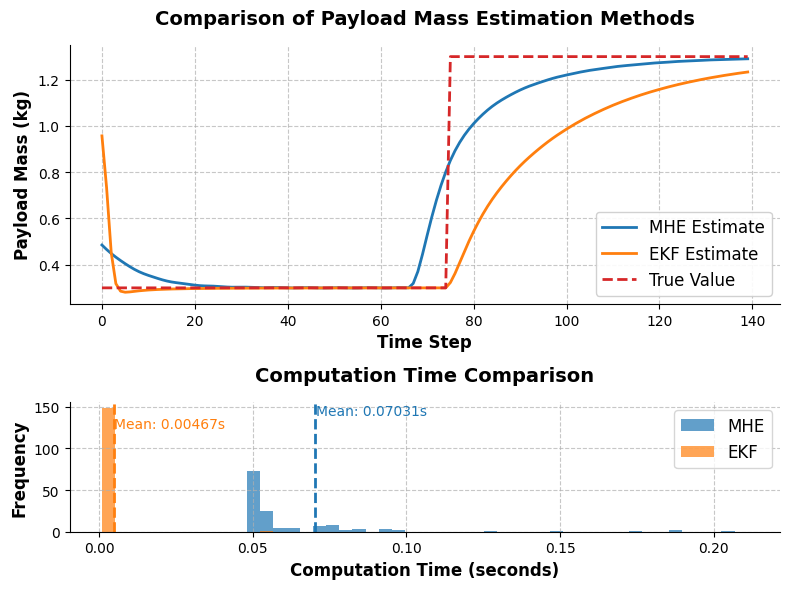

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# Create figure with two subplots (mass estimation and computation time)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [2, 1]})
fig.tight_layout(pad=4)

# Time steps for x-axis
time_steps = np.arange(len(m_p_estimates))

# Plot 1: Mass estimation comparison
ax1.plot(time_steps, m_p_estimates, linewidth=2, color='#1f77b4', label="MHE Estimate")
ax1.plot(time_steps, m_p_estimates_ekf[:len(m_p_estimates)], linewidth=2, color='#ff7f0e', label="EKF Estimate")
ax1.plot(time_steps, x_seq[:len(m_p_estimates), -1], linestyle='--', linewidth=2, color='#d62728', label="True Value")

# Configure first plot
ax1.set_xlabel("Time Step", fontsize=12, fontweight='bold')
ax1.set_ylabel("Payload Mass (kg)", fontsize=12, fontweight='bold')
ax1.set_title("Comparison of Payload Mass Estimation Methods", fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend(loc='best', fontsize=12, framealpha=0.9)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', which='major', labelsize=10)

# Plot 2: Computation time comparison
ax2.set_title("Computation Time Comparison", fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel("Computation Time (seconds)", fontsize=12, fontweight='bold')
ax2.set_ylabel("Frequency", fontsize=12, fontweight='bold')

# Determine bin edges for both histograms
max_time = max(np.quantile(computation_times_mhe, 0.99), np.quantile(computation_times_ekf, 0.99))
min_time = min(min(computation_times_mhe), min(computation_times_ekf))
bins = np.linspace(min_time, max_time, 50)

# Plot histograms with transparency
ax2.hist(computation_times_mhe, bins=bins, alpha=0.7, color='#1f77b4', label="MHE")
ax2.hist(computation_times_ekf, bins=bins, alpha=0.7, color='#ff7f0e', label="EKF")

# Configure second plot
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.legend(loc='upper right', fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.tick_params(axis='both', which='major', labelsize=10)

# Add mean computation time annotations
mean_mhe = np.mean(computation_times_mhe)
mean_ekf = np.mean(computation_times_ekf)
ax2.axvline(mean_mhe, color='#1f77b4', linestyle='--', linewidth=2)
ax2.axvline(mean_ekf, color='#ff7f0e', linestyle='--', linewidth=2)
ax2.annotate(f'Mean: {mean_mhe:.5f}s', xy=(mean_mhe, ax2.get_ylim()[1]*0.9),
            xytext=(mean_mhe+0.0001, ax2.get_ylim()[1]*0.9),
            color='#1f77b4', fontsize=10)
ax2.annotate(f'Mean: {mean_ekf:.5f}s', xy=(mean_ekf, ax2.get_ylim()[1]*0.8),
            xytext=(mean_ekf+0.0001, ax2.get_ylim()[1]*0.8),
            color='#ff7f0e', fontsize=10)

# Format x-axis to scientific notation if values are very small
if max_time < 0.001:
    ax2.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.tight_layout()
plt.show()